# Segundo parcial
## Juan David Salcedo Hernández. 1001577699

A) Los siguientes datos fueron extraidos de un [perfil real de Instragram](https://www.instagram.com/paulacano24/):

https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/data/Followers.json

Interprete los datos como un problema de caida libre y a partir del ajuste (fit) a la correspondiente ecuación de movimiento, determine
1. La velocidad inicial de incremento de seguidores en `followers/hour`
1. La aceleración constante en `followers/hour**2`
1. El número máximo de seguidores que alcanzaría el perfil
1. La fecha en la que se alcanzaría dicho máximo


In [6]:
# Usual imports and graphics configs
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize

In [166]:
# First problem
# We begin by reading the dataframe
path = 'https://raw.githubusercontent.com/restrepo/ComputationalMethods/master/data/Followers.json'
df = pd.read_json(path)
df.head()

,followers,date_time,hours
0,42696,2021-08-04 22:06:53.668,0.000000
1,42706,2021-08-04 23:06:56.517,1.000791
2,42716,2021-08-05 00:06:59.505,2.001621
3,42734,2021-08-05 01:07:02.174,3.002363
4,42749,2021-08-05 02:07:04.854,4.003107


In [208]:
import inspect 

# the following functions are generalised to find fit parameters and maximum values of functions
def model_fit(function, _t, _x):
  # perform the optimisation process and populate the array of predictions
  popt, pcov = optimize.curve_fit(function, _t, _x)
  predictions = function(_t, *popt)

  # define an array of parameter names
  param_names = [i for i in inspect.signature(function).parameters.keys()]
  param_names = np.array(param_names)
  # make a dictionary with parameter names and their corresponding values
  params = {A: B for A, B in zip(param_names[1:], popt)}

  return [params, predictions]

def model_max(function, args, x0=0):
  def _function(x, *params):
    return -function(x, *params)
  # perform the optimisation process
  opt_result = optimize.fmin_powell(_function, x0=x0, args=args, disp=0, full_output=True)
  max_point = opt_result[0]
  max_val = opt_result[1]
  return [float(max_point), -float(max_val)]

[]

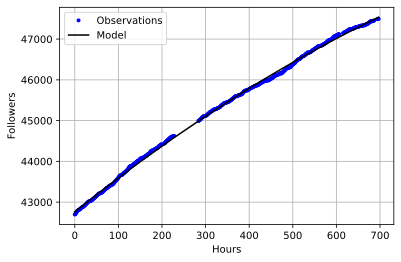

In [168]:
# since we're interpreting this data as a free-fall problem, we may use the formula 
# x = x_ini + v_ini*t - 0.5*a*t**2, where x is the number of followers.
def _free_fall(t, x_ini, v_ini, a):
  return x_ini + v_ini*t - 0.5*a*t**2

# define the optimal params
params = model_fit(_free_fall, df.hours, df.followers)[0]

# define predictions and actual values
predictions = model_fit(_free_fall, df.hours, df.followers)[1]
actual_vals = df.followers
_t = df.hours

# plot the graph of the function
plt.plot(_t, actual_vals, 'b.', label='Observations')
plt.plot(_t, predictions, 'k-', label='Model')

plt.xlabel('Hours')
plt.ylabel('Followers')
plt.legend()
plt.grid()
plt.plot()

In [214]:
# these are the optimal parameters
# notice that the acceleration is intrinsically negative
pd.DataFrame.from_dict(params, orient='index', columns=['Value'])

,Value
x_ini,42761.086004
v_ini,8.552138
a,0.004875


In [215]:
# find the maximum point and maximum value
param_values = tuple(params.values())
x0 = _t[len(_t)-1]
[max_time, max_followers] = model_max(_free_fall, param_values, x0=x0)

import datetime
# convert the amount of hours that need to elaps into a date, and
# add them to the initial time
max_date = df['date_time'][0] + datetime.timedelta(hours = max_time)

print(f'The amount of followers will reach a maximum of {max_followers} at {max_date}, after {max_time} hours')

The amount of followers will reach a maximum of 50262.13655441515 at 2021-10-17 00:18:28.779618, after 1754.1930865606619 hours


B) El período de  un pendulo de longitud $l$ oscilando a ángulos grandes  $\alpha$, está dado por
$$
T=T_{0} \frac{\sqrt{2}}{\pi} \int_{0}^{\alpha} \frac{d \theta}{(\cos \theta-\cos \alpha)^{\frac{1}{2}}}
$$
donde
$$
T_{0}=2 \pi \sqrt{\frac{l}{g}}
$$
es el período del mismo péndulo a pequeñas amplitudes. Culquier intento de evaluación numérico de esa integral debería fallar. Sin embargo, si hacemos el cambio de variable
$$
\sin \frac{\theta}{2}=\sin \frac{\alpha}{2} \sin \phi
$$
obtenemos
$$
T=\frac{2 T_{0}}{\pi} \int_{0}^{\frac{\pi}{2}} \frac{d \phi}{\left(1-\sin ^{2} \frac{\alpha}{2} \sin ^{2} \phi\right)^{\frac{1}{2}}}
$$
que corresponde a una integral bien comportada. 
1. Escriba un programa que use la anterio integral para calcular el cociente  $T/T_0$ para ángulos enteros (en grados) $0^\circ \le\alpha \le 90^\circ$.  
1. Genere un DataFrame de pandas que contenga como columnas: la amplitud en grados, la amplitud en radianes, y el cociente $T/T_0$, 
1. Haga un gráfico de $T/T_0$ como función de $\alpha$ (en grados). 
1. Explain the result when $\alpha = 0.$ 

In [160]:
# Second problem
def integrand(phi, alpha):
  return 1/np.sqrt(1-np.sin(0.5*alpha)**2 * np.sin(phi)**2)

def graph(alpha):
  alpha = np.deg2rad(alpha)
  expression = lambda phi: integrand(phi, alpha)
  value = (2/np.pi)*integrate.quad(expression, 0, np.pi/2)[0]
  return value

# populate the datafarme
df = pd.DataFrame({'degrees': np.linspace(0,90)})
df['radians'] = df.degrees.apply(np.deg2rad)
df['T/T0'] = df.degrees.apply(graph)

df.head()

,degrees,radians,T/T0
0,0.000000,0.000000,1.000000
1,1.836735,0.032057,1.000064
2,3.673469,0.064114,1.000257
3,5.510204,0.096171,1.000578
4,7.346939,0.128228,1.001029


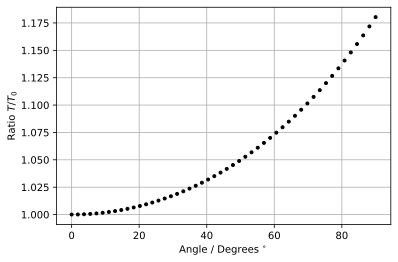

In [164]:
plt.plot(df.degrees, df['T/T0'], 'k.')
plt.xlabel('Angle / Degrees$\,^\circ$')
plt.ylabel('Ratio $T/T_0$')
plt.grid()
plt.show()

By way of explanation, the graph above represents the ''disagreement'' between the period obtained by the small angle approximation (which appears in scads of instances) and the actual period from the computation of a specific elliptic integral. As is well known, such an approximation holds for $\alpha \ll 1$ (in radians, of course), this is the physicists' way of saying that $\alpha$ is a number whose norm is effectively 0, that is, within a certain degree of approximation. Therefore, it is obvious that the approximation becomes perfect when the angle is precisely 0, that is why there is no disagreement in the approximate and exact values, and the ratio is 1.